# Comparing Classification Models

We want to compare various classification models for the "default" dataset. We'll look at logistic regression, LDA, QDA, $k$-nearest neighbors, and all the different trees we tried.

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# We'll look at logistic regression, LDA, QDA, and KNN
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

# We'll standardize and split data into training/testing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Need to measure "goodness"
from sklearn.metrics import accuracy_score, recall_score, average_precision_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_precision_recall_curve

In [2]:
# Read in the data from the .csv file
default = pd.read_csv("default.csv")
default.shape

(10000, 4)

In [3]:
# Take a look at info()
default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


In [4]:
# Create dummies for default and student
defaultCoded = pd.get_dummies(default, drop_first=True)
defaultCoded.sample(11)

,balance,income,default_Yes,student_Yes
7677,65.332984,31992.242221,0,0
1911,605.365694,39002.229643,0,0
2988,634.217926,38672.749647,0,0
716,1060.335860,56607.253973,0,0
8490,663.610199,48089.520547,0,0
3330,1335.131324,17044.365397,0,1
7784,2040.590171,50930.910786,1,0
4797,570.024684,40987.062331,0,0
9822,1609.136059,16373.945359,0,1
9989,999.281112,20013.350644,0,1


## Stratification
In many cases, particularly when you an **imbalanced** dataset, you want your training and test sets to preserve the same proportions of each class (i.e., the thing you are trying to predict) as observed in the original dataset. In our case, we would like to have the training and test set each have 3.33% defaulters. We can split our data using **stratification**.

In [5]:
# Make the X and y variables
# From last time, we saw that income was not statistically significant
#     so let's also drop that column
y = defaultCoded.default_Yes
X = defaultCoded.drop(columns=["default_Yes", "income"])
X.head()

,balance,student_Yes
0,729.526495,0
1,817.180407,1
2,1073.549164,0
3,529.250605,0
4,785.655883,0


In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

In [7]:
# What is the default rates in both training and test??
print(f"Training default rate is {y_train.mean():.2%}")
print(f"Testing default rate is  {y_test.mean():.2%}")

Training default rate is 3.33%
Testing default rate is  3.33%


# Function to Look at Different Models
Can we write a function that will take in different models (classifiers) and compute the different metrics so we can compare the different classifiers easily?

In [9]:
# define our function
def modelMetrics(classifier, name, X_test, y_test):
    """
    We want to see how the different models react to the same 
    dataset. We should capture multiple metrics for each model.
    
    classifier: the classifier we are capturing metrics for
    
    name: a name to identify the classifier
    
    X_test: the X array for the test set
    
    y_test: the output variable (actual) for test set
    """
    retVal = {}
    
    metrics = {}
    predictions = classifier.predict(X_test)
    metrics["a_score"] = accuracy_score(y_test, predictions)
    metrics["r_score"] = recall_score(y_test, predictions)
    metrics["p_score"] = precision_score(y_test, predictions)
    metrics["f1_score"] = f1_score(y_test, predictions)
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    totDefaulters = y_test.sum()
    totNonDefaulters = len(y_test) - totDefaulters
    
    # Error rate non-defaulters = false positives / total non-defaulters
    metrics["errorNondefaulters"] = fp/totNonDefaulters
    # Accuracy for non-defaulters = true negatives / total non-defaulters
    metrics["accNondefaulters"] = tn/totNonDefaulters
    # Error rate for defaulters = false negatives / total defaulters
    metrics["errorDefaulters"] = fn/totDefaulters
    # Accuracy for defaulters = true positives / total defaulters
    metrics["accDefaulters"] = tp/totDefaulters
    # ROC AUC score
    metrics["roc_auc_score"] = roc_auc_score(y_test,
                                             classifier.predict_proba(X_test)[:,1])
    # Average precision score
    metrics["avg_p_score"] = average_precision_score(y_test,
                                                     classifier.predict_proba(X_test)[:,1])
    
    retVal[name] = metrics
    
    return retVal

## Logistic Regression

We'll use `StandardScaler` to standardize the $X$ variable. 

In [10]:
# Create the StandardScaler and fit
scaler = StandardScaler().fit(X_train)
# Scale training and test Xs
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [15]:
# First, create the LogisticRegression instance
logReg = LogisticRegression()
# Now fit the logistic regression model with the scaled X and unscaled y
logReg.fit(X_train_s, y_train)

LogisticRegression()

In [16]:
# Call our function to get metrics - let's also put it in DataFrame
dfLogReg = pd.DataFrame(modelMetrics(logReg,"LogisticRegression",X_test_s, y_test))
dfLogReg

,LogisticRegression
a_score,0.972333
accDefaulters,0.330000
accNondefaulters,0.994483
avg_p_score,0.503314
errorDefaulters,0.670000
errorNondefaulters,0.005517
f1_score,0.442953
p_score,0.673469
r_score,0.330000
roc_auc_score,0.951041


# Linear Discriminant Analysis
Let's now try LDA. We already imported the appropriate packages for LDA.

In [26]:
# Create an LDA instance
lda = LDA()
# Fit the LDA model with X and y training set created previously
lda.fit(X_train_s, y_train)

LinearDiscriminantAnalysis()

In [28]:
# Call our function to get metrics - let's also put it in DataFrame
dfLDA = pd.DataFrame(modelMetrics(lda,"LDA",X_test_s, y_test))
dfLDA

,LDA
a_score,0.971333
accDefaulters,0.250000
accNondefaulters,0.996207
avg_p_score,0.502443
errorDefaulters,0.750000
errorNondefaulters,0.003793
f1_score,0.367647
p_score,0.694444
r_score,0.250000
roc_auc_score,0.950731


# Quadratic Discriminant Analysis
We can also try QDA (already imported package)

In [32]:
# Create a QDA instance
qda = QuadraticDiscriminantAnalysis()
# Fit the qda with X and y
qda.fit(X_train_s, y_train)

QuadraticDiscriminantAnalysis()

In [58]:
# Call our function to get metrics - let's also put it in DataFrame
dfQDA = pd.DataFrame(modelMetrics(qda, "QuadraticDiscriminantAnalysis",X_test_s, y_test))
dfQDA

,QuadraticDiscriminantAnalysis
a_score,0.972667
accDefaulters,0.300000
accNondefaulters,0.995862
avg_p_score,0.496253
errorDefaulters,0.700000
errorNondefaulters,0.004138
f1_score,0.422535
p_score,0.714286
r_score,0.300000
roc_auc_score,0.950645


# KNN
Might as well try $k$-nearest neighbors. You pick $k$, so it will be your fault not mine.

In [19]:
# Let's use k=9
knn = KNeighborsClassifier(n_neighbors=9)
# fit the model
knn.fit(X_train_s, y_train)

KNeighborsClassifier(n_neighbors=9)

In [22]:
# Call our function to get metrics - let's also put it in DataFrame
dfKNN = pd.DataFrame(modelMetrics(knn, "KNN",X_test_s, y_test))
dfKNN

,KNN
a_score,0.970667
accDefaulters,0.380000
accNondefaulters,0.991034
avg_p_score,0.361938
errorDefaulters,0.620000
errorNondefaulters,0.008966
f1_score,0.463415
p_score,0.593750
r_score,0.380000
roc_auc_score,0.858034


## DecisionTreeClassifier
Need to import the class.

In [23]:
# Import
from sklearn.tree import DecisionTreeClassifier
# Create the tree
dt = DecisionTreeClassifier()
# fit the tree on the scaled X training data
dt.fit(X_train_s, y_train)

DecisionTreeClassifier()

In [24]:
# Call our function to get metrics - let's also put it in DataFrame
dfDTS = pd.DataFrame(modelMetrics(dt, "DecisionTreeClassifier",X_test_s, y_test))
dfDTS

,DecisionTreeClassifier
a_score,0.954667
accDefaulters,0.350000
accNondefaulters,0.975517
avg_p_score,0.137233
errorDefaulters,0.650000
errorNondefaulters,0.024483
f1_score,0.339806
p_score,0.330189
r_score,0.350000
roc_auc_score,0.662759


In [30]:
# Creat a decision tree on UNSCALED X
dt2 = DecisionTreeClassifier()
dt2.fit(X_train, y_train)

DecisionTreeClassifier()

In [31]:
# Call our function to get metrics - let's also put it in DataFrame
dfDTUS = pd.DataFrame(modelMetrics(dt2, "DT-Unscaled",X_test, y_test))
dfDTUS

,DT-Unscaled
a_score,0.954667
accDefaulters,0.350000
accNondefaulters,0.975517
avg_p_score,0.137233
errorDefaulters,0.650000
errorNondefaulters,0.024483
f1_score,0.339806
p_score,0.330189
r_score,0.350000
roc_auc_score,0.662759


In [34]:
# Try a different max_depth
dt3 = DecisionTreeClassifier(max_depth =6, random_state=42)
dt3.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

In [35]:
# Call our function to get metrics - let's also put it in DataFrame
dfDT6 = pd.DataFrame(modelMetrics(dt3, "DT-Depth_6",X_test, y_test))
dfDT6

,DT-Depth_6
a_score,0.968000
accDefaulters,0.310000
accNondefaulters,0.990690
avg_p_score,0.381994
errorDefaulters,0.690000
errorNondefaulters,0.009310
f1_score,0.392405
p_score,0.534483
r_score,0.310000
roc_auc_score,0.876579


## BaggingClassifier
Need to import.

In [36]:
from sklearn.ensemble import BaggingClassifier

In [37]:
# Create a bag
bag = BaggingClassifier()
# Fit it
bag.fit(X_train, y_train)

BaggingClassifier()

In [38]:
# Call our function to get metrics - let's also put it in DataFrame
dfBag = pd.DataFrame(modelMetrics(bag, "Bagging",X_test, y_test))
dfBag

,Bagging
a_score,0.956667
accDefaulters,0.330000
accNondefaulters,0.978276
avg_p_score,0.284543
errorDefaulters,0.670000
errorNondefaulters,0.021724
f1_score,0.336735
p_score,0.343750
r_score,0.330000
roc_auc_score,0.789898


## RandomForestClassifier
Need to import.

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
# Create random forest
rf = RandomForestClassifier()
# fit it
rf.fit(X_train, y_train)

RandomForestClassifier()

In [60]:
# Call our function to get metrics - let's also put it in DataFrame
dfRf = pd.DataFrame(modelMetrics(rf, "RandomForest",X_test, y_test))
dfRf

,RandomForest
a_score,0.954000
accDefaulters,0.360000
accNondefaulters,0.974483
avg_p_score,0.317787
errorDefaulters,0.640000
errorNondefaulters,0.025517
f1_score,0.342857
p_score,0.327273
r_score,0.360000
roc_auc_score,0.820909


## Extremely Randomized Trees
Need to import.

In [42]:
from sklearn.ensemble import ExtraTreesClassifier

In [43]:
# Create it
xtc = ExtraTreesClassifier()
# Fit it
xtc.fit(X_train, y_train)

ExtraTreesClassifier()

In [44]:
# Call our function to get metrics - let's also put it in DataFrame
dfXTC = pd.DataFrame(modelMetrics(xtc, "Extra Trees",X_test, y_test))
dfXTC

,Extra Trees
a_score,0.954667
accDefaulters,0.380000
accNondefaulters,0.974483
avg_p_score,0.239061
errorDefaulters,0.620000
errorNondefaulters,0.025517
f1_score,0.358491
p_score,0.339286
r_score,0.380000
roc_auc_score,0.747143


## AdaBoost
Need to import.

In [45]:
from sklearn.ensemble import AdaBoostClassifier

In [46]:
# Create it
ada = AdaBoostClassifier()
# fit it
ada.fit(X_train, y_train)

AdaBoostClassifier()

In [47]:
# Call our function to get metrics - let's also put it in DataFrame
dfAda = pd.DataFrame(modelMetrics(ada, "ADA",X_test, y_test))
dfAda

,ADA
a_score,0.970333
accDefaulters,0.400000
accNondefaulters,0.990000
avg_p_score,0.438557
errorDefaulters,0.600000
errorNondefaulters,0.010000
f1_score,0.473373
p_score,0.579710
r_score,0.400000
roc_auc_score,0.951383


## Gradient Boosting
Need to import.

In [48]:
from sklearn.ensemble import GradientBoostingClassifier

In [49]:
# Create it
gbc = GradientBoostingClassifier()
# fit it
gbc.fit(X_train,y_train)

GradientBoostingClassifier()

In [50]:
# Call our function to get metrics - let's also put it in DataFrame
dfGbc = pd.DataFrame(modelMetrics(gbc, "GradientBoost",X_test, y_test))
dfGbc

,GradientBoost
a_score,0.967333
accDefaulters,0.360000
accNondefaulters,0.988276
avg_p_score,0.395060
errorDefaulters,0.640000
errorNondefaulters,0.011724
f1_score,0.423529
p_score,0.514286
r_score,0.360000
roc_auc_score,0.946391


## XGBoost
Need to import.

In [51]:
import xgboost as xgb

In [55]:
# Create it
xgbClf = xgb.XGBClassifier()
# fit it
xgbClf.fit(X_train, y_train)

[14:44:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/leckan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
# Call our function to get metrics - let's also put it in DataFrame
dfXGB = pd.DataFrame(modelMetrics(xgbClf, "XGBoost",X_test, y_test))
dfXGB

,XGBoost
a_score,0.968333
accDefaulters,0.340000
accNondefaulters,0.990000
avg_p_score,0.437857
errorDefaulters,0.660000
errorNondefaulters,0.010000
f1_score,0.417178
p_score,0.539683
r_score,0.340000
roc_auc_score,0.943986


## Look at All Metrics

In [61]:
# Make a list called allDfs that contains all the DataFrames
# we created that contain the model metrics
allDfs = [dfLogReg, dfLDA, dfQDA, dfKNN, dfDTS, dfDTUS, dfDT6, dfBag, dfRf, dfXTC, dfAda, dfGbc, dfXGB]

In [63]:
# Concatenate all the DataFrames
pd.concat(allDfs, axis=1)

,LogisticRegression,LDA,QuadraticDiscriminantAnalysis,KNN,DecisionTreeClassifier,DT-Unscaled,DT-Depth_6,Bagging,RandomForest,Extra Trees,ADA,GradientBoost,XGBoost
a_score,0.972333,0.971333,0.972667,0.970667,0.954667,0.954667,0.968000,0.956667,0.954000,0.954667,0.970333,0.967333,0.968333
accDefaulters,0.330000,0.250000,0.300000,0.380000,0.350000,0.350000,0.310000,0.330000,0.360000,0.380000,0.400000,0.360000,0.340000
accNondefaulters,0.994483,0.996207,0.995862,0.991034,0.975517,0.975517,0.990690,0.978276,0.974483,0.974483,0.990000,0.988276,0.990000
avg_p_score,0.503314,0.502443,0.496253,0.361938,0.137233,0.137233,0.381994,0.284543,0.317787,0.239061,0.438557,0.395060,0.437857
errorDefaulters,0.670000,0.750000,0.700000,0.620000,0.650000,0.650000,0.690000,0.670000,0.640000,0.620000,0.600000,0.640000,0.660000
errorNondefaulters,0.005517,0.003793,0.004138,0.008966,0.024483,0.024483,0.009310,0.021724,0.025517,0.025517,0.010000,0.011724,0.010000
f1_score,0.442953,0.367647,0.422535,0.463415,0.339806,0.339806,0.392405,0.336735,0.342857,0.358491,0.473373,0.423529,0.417178
p_score,0.673469,0.694444,0.714286,0.593750,0.330189,0.330189,0.534483,0.343750,0.327273,0.339286,0.579710,0.514286,0.539683
r_score,0.330000,0.250000,0.300000,0.380000,0.350000,0.350000,0.310000,0.330000,0.360000,0.380000,0.400000,0.360000,0.340000
roc_auc_score,0.951041,0.950731,0.950645,0.858034,0.662759,0.662759,0.876579,0.789898,0.820909,0.747143,0.951383,0.946391,0.943986


In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz, export_text, plot_tree

In [65]:
baseDT = DecisionTreeClassifier()

In [68]:
ccps= np.arange(0.001,0.1,0.001)
ccps

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099])

In [69]:
clf = GridSearchCV(baseDT, {'ccp_alpha':ccps}, scoring ="recall", verbose=1)

In [70]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099])},
             scoring='recall', verbose=1)

In [71]:
clf.best_score_

0.49380203515263643

In [72]:
clf.best_params_

{'ccp_alpha': 0.003}

In [74]:
bestDt = DecisionTreeClassifier(ccp_alpha = clf.best_params_["ccp_alpha"],random_state=42)
bestDt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.003, random_state=42)

In [80]:
print(classification_report(y_test, bestDt.predict(X_test), target_names=["No","Yes"]))

              precision    recall  f1-score   support

          No       0.98      0.98      0.98      2900
         Yes       0.52      0.48      0.50       100

    accuracy                           0.97      3000
   macro avg       0.75      0.73      0.74      3000
weighted avg       0.97      0.97      0.97      3000



[Text(167.4, 163.07999999999998, 'balance <= 1800.002\ngini = 0.064\nsamples = 7000\nvalue = [6767, 233]'),
 Text(83.7, 54.360000000000014, 'gini = 0.034\nsamples = 6805\nvalue = [6686, 119]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.486\nsamples = 195\nvalue = [81, 114]')]

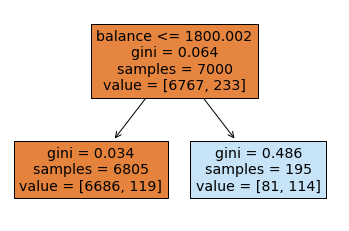

In [81]:
plot_tree(bestDt, feature_names=X.columns, filled=True)